# Polynomial model fit

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.polynomial.polynomial as P
import pandas as pd
import glob
import os
import math
import importlib
%matplotlib inline

import amaizeing_utils as maize

In /home/ejam/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/ejam/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/ejam/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/ejam/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/ejam/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_c

## Wrangle the input file

Load the data file

In [140]:
src = '../2019_G2F_Shared/'
data = pd.read_excel(src + '2019GXEleaf_angle.xlsx', engine='openpyxl')
data.replace(['90+', '90++'], 90, inplace=True)
print(data.shape)
data.head()

(500, 30)


,Unnamed: 0,plot,Pass,Range,Rep,New_Pedigree,Old_Pedigree,Old_Source,Shared,LPlant.L1.End.Angle,...,RPlant.L1.End.Angle,RPlant.L1.End.Length,RPlant.L1.Mid.Angle,RPlant.L1.Mid.Length,RPlant.L1.Stem.Angle,RPlant.L2.End.Angle,RPlant.L2.End.Length,RPlant.L2.Mid.Angle,RPlant.L2.Mid.Length,RPlant.L2.Stem.Angle
0,1,MIH119_1001,3,2,1,2369/LH123HT,2369/LH123HT,NaN,1.0,60.0,...,65.0,58.0,55.0,66.0,26.0,90.0,46.0,50.0,47.0,31.0
1,2,MIH119_1002,4,2,1,2369/LH123HT,2369/LH123HT,NaN,1.0,45.0,...,53.0,59.0,33.0,63.0,23.0,75.0,43.0,43.0,48.0,15.0
2,3,MIH119_1003,5,2,1,B37/H95,B73/PHN82,NaN,NaN,65.0,...,61.0,62.0,48.0,70.0,25.0,43.0,46.0,33.0,65.0,27.0
3,4,MIH119_1004,6,2,1,B37/H95,B14A/H95,NaN,NaN,70.0,...,75.0,52.0,54.0,58.0,23.0,85.0,69.0,48.0,49.0,33.0
4,5,MIH119_1005,7,2,1,B37/H95,B73/PHM49,NaN,NaN,90.0,...,64.0,48.0,45.0,60.0,20.0,90.0,45.0,52.0,39.0,29.0


Separate the metadata from the measurements themselves

In [141]:
meta = data.iloc[:, 1:9]
meta.head()

,plot,Pass,Range,Rep,New_Pedigree,Old_Pedigree,Old_Source,Shared
0,MIH119_1001,3,2,1,2369/LH123HT,2369/LH123HT,NaN,1.0
1,MIH119_1002,4,2,1,2369/LH123HT,2369/LH123HT,NaN,1.0
2,MIH119_1003,5,2,1,B37/H95,B73/PHN82,NaN,NaN
3,MIH119_1004,6,2,1,B37/H95,B14A/H95,NaN,NaN
4,MIH119_1005,7,2,1,B37/H95,B73/PHM49,NaN,NaN


This file contains actually measurements from four different plants. Identify the column number where a different plant starts

In [142]:
lengthCols = [1, 3]
angleCols = [0, 2, 4]

In [143]:
endAngle = []
for i,name in enumerate(data.columns):
    if "End.Angle" in name:
        print('{}:\t{}'.format(i,name))
        endAngle.append(i)

9:	LPlant.L1.End.Angle
14:	LPlant.L2.End.Angle
20:	RPlant.L1.End.Angle
25:	RPlant.L2.End.Angle


Get the five different measures for a plant
- Three angles with respect to the stem
- Two distances from the base

In [174]:
bladeset = 2

numbers = data.iloc[:, endAngle[bladeset]:(endAngle[bladeset]+5)].dropna(axis='index', how='any')
print(numbers.shape)

numbers = numbers.loc[(numbers.iloc[:,2] != 90) & (numbers.iloc[:,4] != 90)]

#numbers = numbers[numbers[data.columns[endAngle[bladeset]]] != 90]

print(numbers.shape)
#numbers.iloc[65]
numbers.head()

(480, 5)
(480, 5)


,RPlant.L1.End.Angle,RPlant.L1.End.Length,RPlant.L1.Mid.Angle,RPlant.L1.Mid.Length,RPlant.L1.Stem.Angle
0,65.0,58.0,55.0,66.0,26.0
1,53.0,59.0,33.0,63.0,23.0
2,61.0,62.0,48.0,70.0,25.0
3,75.0,52.0,54.0,58.0,23.0
4,64.0,48.0,45.0,60.0,20.0


Concatenate the metadata with the information specific of this side of the plot. 

In [175]:
plotname = '_'.join(data.columns[endAngle[bladeset]].split('.')[:2])
print(plotname)
PlotData = pd.concat([meta, numbers], axis=1, join='inner')
PlotData.head()

RPlant_L1


,plot,Pass,Range,Rep,New_Pedigree,Old_Pedigree,Old_Source,Shared,RPlant.L1.End.Angle,RPlant.L1.End.Length,RPlant.L1.Mid.Angle,RPlant.L1.Mid.Length,RPlant.L1.Stem.Angle
0,MIH119_1001,3,2,1,2369/LH123HT,2369/LH123HT,NaN,1.0,65.0,58.0,55.0,66.0,26.0
1,MIH119_1002,4,2,1,2369/LH123HT,2369/LH123HT,NaN,1.0,53.0,59.0,33.0,63.0,23.0
2,MIH119_1003,5,2,1,B37/H95,B73/PHN82,NaN,NaN,61.0,62.0,48.0,70.0,25.0
3,MIH119_1004,6,2,1,B37/H95,B14A/H95,NaN,NaN,75.0,52.0,54.0,58.0,23.0
4,MIH119_1005,7,2,1,B37/H95,B73/PHM49,NaN,NaN,64.0,48.0,45.0,60.0,20.0


Separate the columns that measure angles from the columns that measure distances.

In [176]:
degs = np.flip(np.array(numbers.drop(columns=numbers.columns[lengthCols]), 
                        dtype=np.float), axis=1)
lengths = np.flip(np.array(numbers.drop(columns=numbers.columns[angleCols]), 
                        dtype=np.float), axis=1)

## Fit two simple polynomials, one going upwards, other downwards

### Shower thoughts

$$f_{\text{base to apex}}(x) = A_1(x-B)^{N_1} + C$$
$$g_{\text{apex to tip}}(x) = A_2(x-B)^{N_2} + C$$

- The problem is to find $A_1,A_2,B,C,N_1,N_2$ adequate.
- ~~Main issue is that $N$ must be a natural number.~~
- ~~This is usually not the case when solving the equation.~~
- ~~Use $\lceil N\rceil$ (ceil) or $\lfloor N\rfloor$ (floor) instead.~~ 


Inspired by the following

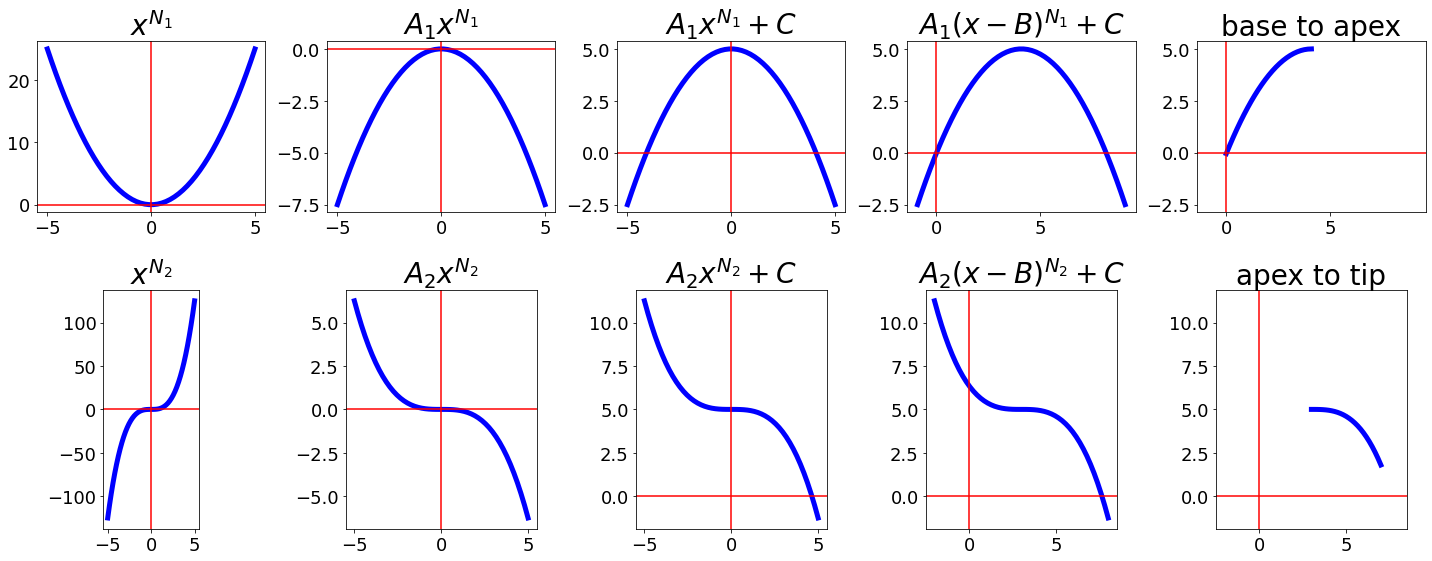

In [9]:
maize.shower_thought()

## Main problem: we don't know the angle formed by the tip of the leaf dangling.

- We can solve easily the first half: from base to top.
    - We know the angle formed by the base of the leaf with the stem
    
- We do not have an extra angle measure when it comes to the tip
    - We initially that the leaf dangles with the same angle as the one between the base and the stem.
    - Then we correct that angle if the the resulting polynomial model is too steep (low $N_2$) or too flat (high $N_2$)
    - We make sure the new $N_2$ is similar to $N_1$, so the curve appear smooth.
- We also limit possible values to $1.0\leq N_1 \leq 2.25$. Any values higher than that would produce curves that look too flat or too steep.

In [177]:
importlib.reload(maize)
idx = 12

deg = np.sort(degs[idx])
length = lengths[idx]
deg = 90 - deg
if deg[0] > 89:
    deg[0] = 89
print(deg)
print(length)

#wblade, wparams = maize.poly_weight_blade_fit(deg, length, 100, dangle_correction=True)
#ublade, uparams = maize.poly_weight_blade_fit(deg, length, 100, dangle_correction=False)

blade, params, downcurl = maize.poly_blade_fit(deg, length, 100, True, thr=2.25)
print('downcurl: ', downcurl)
#dblade, dparams, _ = maize.poly_blade_fit(deg, length, 100, dangle_correction=False)

[55. 35. 18.]
[64. 71.]
downcurl:  False


In [178]:
A,N,B,M, a,b,c,d = params
print(N < 1.1)

b1 = ((M > N +.25) or (M > 2.5))
b2 = ((M < N -.25) or (M < .25))

print(b1,b2)

False
False False


	Model:	poly dangle tweak
Up::::	A = 1.14e-02	N = 2.04
Down::	B = -1.09e-01	M = 1.81
--------
a = 52.43	c = 36.71
b = 67.53	d = 21.94
-------


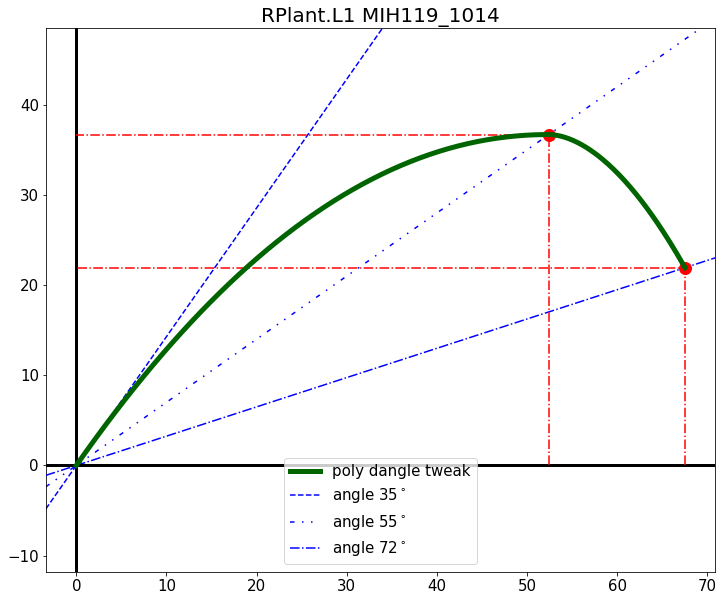

In [179]:
importlib.reload(maize)
title = '.'.join(numbers.columns[0].split('.')[:2]) + ' ' + PlotData.iloc[idx,0]
maize.plot_poly_blade([blade], deg, 
                      [params], title=title, 
                      labels=['poly dangle tweak'], 
                      verbose=True)

In [22]:
dst = '../model/' + plotname + '/'
if not os.path.isdir(dst):
    os.makedirs(dst)
print(dst)

../model/LPlant_L1/


KeyboardInterrupt: 

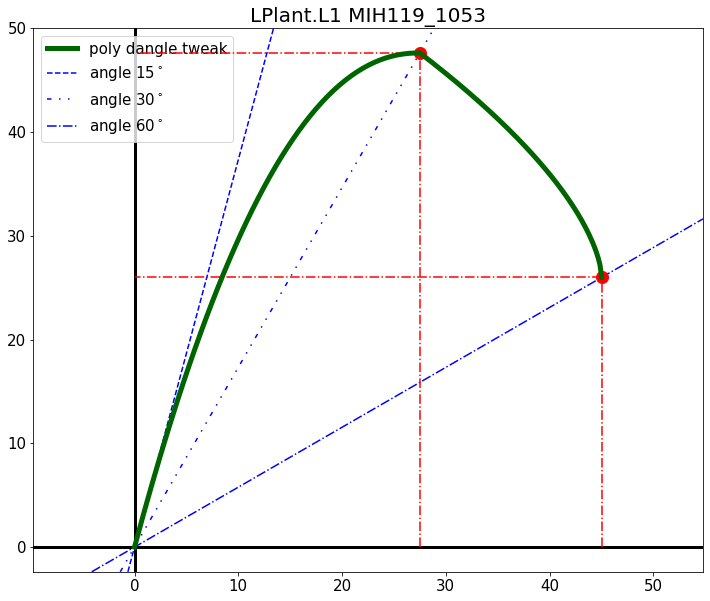

In [23]:
importlib.reload(maize)
idx = 12

for idx in range(0,len(degs)):
    deg = np.sort(degs[idx])
    length = lengths[idx]
    deg = 90 - deg
    if deg[0] > 89:
        deg[0] = 89
    blade, params, _ = maize.poly_blade_fit(deg, length, 100)
    title = '.'.join(numbers.columns[0].split('.')[:2]) + ' ' + PlotData.iloc[idx,0]
    maize.plot_poly_blade([blade], deg, 
                          [params], title=title, 
                          labels=['poly dangle tweak'], 
                          writefig=True, dst=dst, dpi=72)

## 

## Compute the polynomial coefficients for the rest of leaves

In [180]:
importlib.reload(maize)
resol = 100
Params= np.empty((len(degs), 8))
NormBlade = []
Extra = np.empty((len(degs), 4))

for idx in range(len(degs)):
    deg = np.sort(degs[idx])
    length = lengths[idx]
    deg = 90 - deg
    if deg[0] > 89:
        deg[0] = 89
    
    blade, params, down_curled = maize.poly_blade_fit(deg, length, resol)
    b, up, dw = maize.blade_lengths(blade, resol, down_curled)
    
    Params[idx,:] = params
    Extra[idx, :] = b, up, dw, down_curled

## Save the coefficients in a CSV

In [181]:
dst = '../model/'
param_df = pd.DataFrame(np.column_stack((Params,Extra)), 
                        index=PlotData.index, 
                        columns=['A1','N1','A2','N2','a','b','c','d','total_blade_length', 'upblade_length', 'downblade_length', 'curled'])
df = pd.concat([PlotData, param_df], axis=1, join='inner')

In [182]:
df.loc[df['total_blade_length'].isna()]

,plot,Pass,Range,Rep,New_Pedigree,Old_Pedigree,Old_Source,Shared,RPlant.L1.End.Angle,RPlant.L1.End.Length,...,A2,N2,a,b,c,d,total_blade_length,upblade_length,downblade_length,curled


In [183]:
df.to_csv(dst + plotname + '_poly_model.csv', index=True)
df

,plot,Pass,Range,Rep,New_Pedigree,Old_Pedigree,Old_Source,Shared,RPlant.L1.End.Angle,RPlant.L1.End.Length,...,A2,N2,a,b,c,d,total_blade_length,upblade_length,downblade_length,curled
0,MIH119_1001,3,2,1,2369/LH123HT,2369/LH123HT,NaN,1.0,65.0,58.0,...,0.000000,0.000000,54.064035,52.565852,37.856045,24.511859,69.227036,69.227036,0.000000,1.0
1,MIH119_1002,4,2,1,2369/LH123HT,2369/LH123HT,NaN,1.0,53.0,59.0,...,-0.636564,1.295705,34.312259,47.119495,52.836246,35.507086,85.892134,64.178939,21.713195,0.0
2,MIH119_1003,5,2,1,B37/H95,B73/PHN82,NaN,NaN,61.0,62.0,...,0.000000,0.000000,52.020138,54.226422,46.839142,30.058196,73.990484,73.990484,0.000000,1.0
3,MIH119_1004,6,2,1,B37/H95,B14A/H95,NaN,NaN,75.0,52.0,...,-1.558637,2.160696,46.922986,50.228143,34.091545,13.458590,82.101898,60.917096,21.184802,0.0
4,MIH119_1005,7,2,1,B37/H95,B73/PHM49,NaN,NaN,64.0,48.0,...,0.000000,0.000000,42.426407,43.142114,42.426407,21.041815,63.547638,63.547638,0.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,MIH119_2246,11,19,2,PHW65_MoG_0633/PHT69,PHW65_MoG_0633/PHT69,WIPV17/31195,1.0,86.0,50.0,...,-1.576399,1.076938,34.528310,49.878203,33.343602,3.487824,82.023978,48.437669,33.586310,0.0
496,MIH119_2247,10,19,2,PHW65_MoG_0651/PHT69,PHW65_MoG_0651/PHT69,WIPV17/31196,1.0,78.0,63.0,...,-0.274561,1.294823,37.303006,61.623299,30.207379,13.098437,78.778863,48.849361,29.929501,0.0
497,MIH119_2248,9,19,2,PHW65_MoG_0660/PHT69,PHW65_MoG_0660/PHT69,WIPV17/31197,1.0,66.0,72.0,...,-0.125909,1.654014,43.066770,65.775273,51.324978,29.285038,102.178515,69.702245,32.476270,0.0
498,MIH119_2249,8,19,2,PHW65_MoG_0662/PHT69,PHW65_MoG_0662/PHT69,WIPV17/31198,1.0,90.0,59.0,...,-0.238733,1.475371,33.207222,59.000000,28.866597,0.000000,84.593364,45.224947,39.368418,0.0


# Load and merge the data

In [186]:
np.max(data[3]['total_blade_length'])

122.50958653882164

In [184]:
dst = '../model/'
polymodel_files = sorted(glob.glob('../model/*poly_model.csv'))
data = [None for i in range(len(polymodel_files))]
for i in range(len(polymodel_files)):
    data[i] = pd.read_csv(polymodel_files[i], index_col='Unnamed: 0')
    data[i] = data[i].iloc[np.all(data[i].iloc[:, [8,10,12]].values < 91, axis=1)]

plotname = ['_'.join(os.path.split(polymodel_files[i])[1].split('_')[:2]) for i in range(len(polymodel_files))]

In [111]:
for i in range(len(data[0].columns)):
    print(i,data[0].columns[i], sep='\t')

0	plot
1	Pass
2	Range
3	Rep
4	New_Pedigree
5	Old_Pedigree
6	Old_Source
7	Shared
8	LPlant.L1.End.Angle
9	LPlant.L1.End.Length
10	LPlant.L1.Mid.Angle
11	LPlant.L1.Mid.Length
12	LPlant.L1.Stem.Angle
13	A1
14	N1
15	A2
16	N2
17	a
18	b
19	c
20	d
21	total_blade_length
22	upblade_length
23	downblade_length
24	curled


In [187]:
resol = 100
XRange = []
UPxrange = []
DWxrange = []

BLade = []
UPblade = []
DWblade = []

for idx in range(len(data)):
    Xrange = np.empty((len(data[idx]), 2*resol))
    Upxrange = np.empty((len(data[idx]), resol))
    Dwxrange = Upxrange.copy()
    
    Blade = np.empty((len(data[idx]), 2*resol))
    Upblade = np.empty((len(data[idx]), resol))
    Dwblade = Upblade.copy()
    
    for i in range(len(data[idx])):

        A,N,B,M, a,b,c,d = data[idx].iloc[i, 13:21].values
        down_curled = data[idx].iloc[i,-1]

        upxrange = np.linspace(0, a, resol)
        blade_up = maize.polycurve_up(upxrange, A, N, a, c)

        if not down_curled:
            dwxrange = np.linspace(a,b,resol)
            blade_dw = maize.polycurve_dw(dwxrange, B, M, a, c)

        else:
            dwxrange = np.zeros(len(upxrange)) + upxrange[-1]
            blade_dw = np.zeros(len(upxrange)) + blade_up[-1]

        xrange = np.hstack((upxrange, dwxrange))
        blade = np.hstack((blade_up, blade_dw))
        
        Xrange[i] = xrange
        Upxrange[i] = upxrange
        Dwxrange[i] = dwxrange
        
        Blade[i] = blade
        Upblade[i] = blade_up
        Dwblade[i] = blade_dw
        
    XRange.append(Xrange)
    UPxrange.append(Upxrange)
    DWxrange.append(Dwxrange)
    
    BLade.append(Blade)
    UPblade.append(Upblade)
    DWblade.append(Dwblade)

In [113]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

RPlant_L2
../model/poly_model_RPlant_L2_blades.png


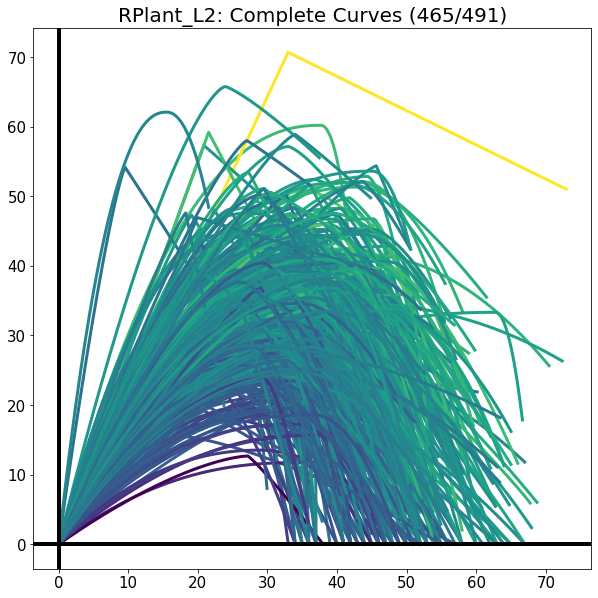

In [264]:
idx = 3
print(plotname[idx])
plt.figure(figsize=(10,10))

max_l = np.ceil(np.max(data[idx]['total_blade_length']))
complete = np.nonzero(1 - data[idx]['curled'].values)[0]
color_vals = (data[idx].iloc[complete,21] - np.min(data[idx].iloc[complete,21])).values
color_vals /= np.max(color_vals)
viridis = cm.get_cmap('viridis', 64)

for k,i in enumerate(complete):
    plt.plot(XRange[idx][i], BLade[idx][i], lw=3, c=viridis(color_vals[k]))

plt.axvline(x=0, c='k', lw=4)
plt.axhline(y=0, c='k', lw=4)
plt.title(plotname[idx] + ': Complete Curves ({}/{})'.format(len(complete),len(data[idx])),
          fontsize=20)
plt.tick_params(labelsize=15)
plt.axis('scaled');
plt.margins(0.05)

filename = dst + 'poly_model_' + plotname[idx] + '_blades.png'
print(filename)
plt.savefig(filename, dpi=150, format='png', bbox_inches='tight', facecolor='white', transparent=False)

# Plot all

In [306]:
antifoo[0]

array([  1,   3,  21, 144, 186, 192, 254, 310, 356, 365, 417, 455])

../model/poly_model_all_blades.png


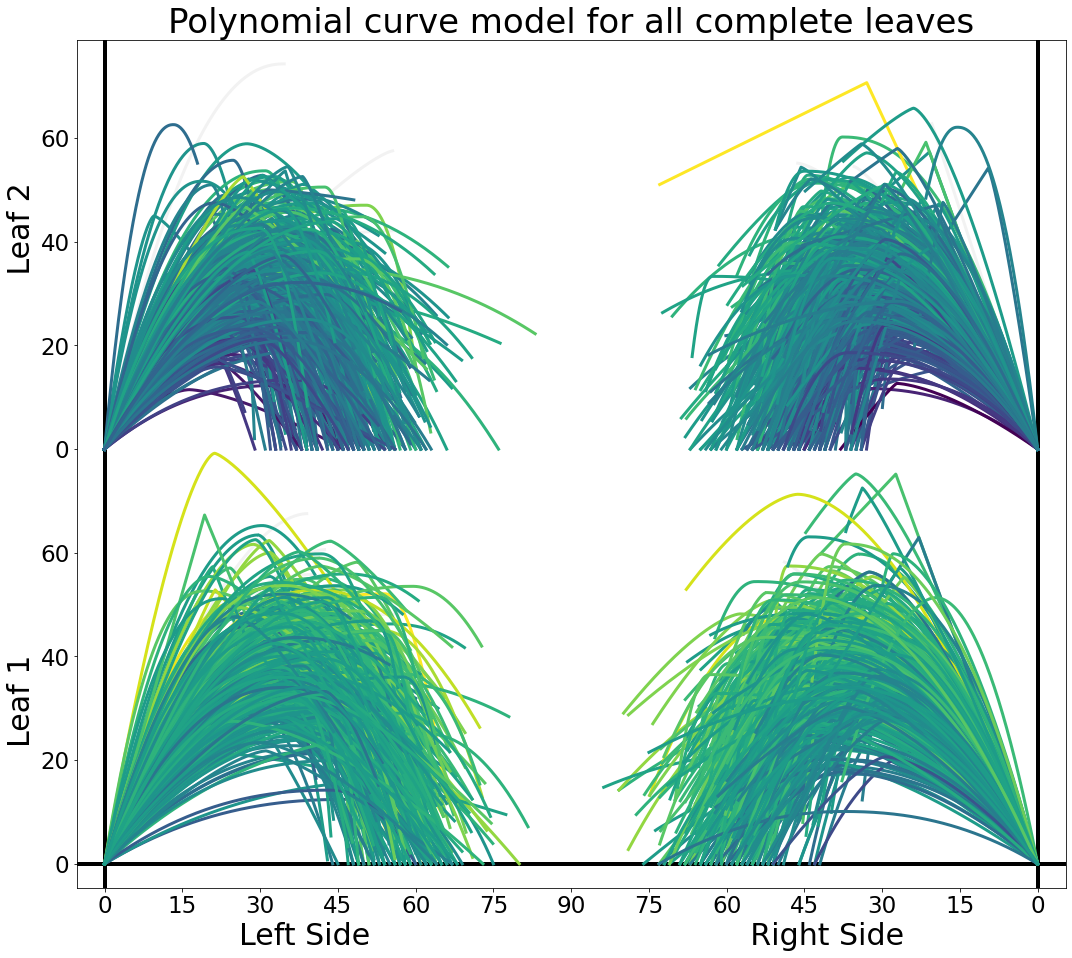

In [312]:
foo = [np.nonzero(1 - data[i]['curled'].values)[0] for i in range(len(data))]
antifoo = [np.nonzero(data[i]['curled'].values)[0] for i in range(len(data))]
bar = [(data[i].iloc[foo[i],21]).values for i in range(len(data))]
mbar = np.min(np.hstack(bar))
Mbar = np.max(np.hstack(bar) - mbar)

color_vals = [(bar[i] - mbar)/Mbar for i in range(len(data))]

fs = 30
viridis = cm.get_cmap('viridis', 64)

xsep = 90; ysep = 80
fig, ax = plt.subplots(1,1, figsize=(15,15), sharex=True, sharey=True)
#ax = np.atleast_1d(ax).ravel()
#porder = [(1,0), (0,0), (1,1), (0,1)]
#psign = [1,1,-1,-1]
viridis = cm.get_cmap('viridis', 32)

i = 0
for j in range(len(foo[i])):
    ax.plot(XRange[i][foo[i][j]], BLade[i][foo[i][j]], lw=3, c=viridis(color_vals[i][j]), zorder=4)
for j in range(len(antifoo[i][:10])):
    ax.plot(XRange[i][antifoo[i][j]], BLade[i][antifoo[i][j]], lw=3, c='gray', alpha=0.1, zorder=1)
            
i = 1
for j in range(len(foo[i])):
    ax.plot(XRange[i][foo[i][j]], ysep+BLade[i][foo[i][j]], lw=3, c=viridis(color_vals[i][j]), zorder=4)
for j in range(len(antifoo[i][:10])):
    ax.plot(XRange[i][antifoo[i][j]], ysep + BLade[i][antifoo[i][j]], lw=3, c='gray', alpha=0.1, zorder=1)
    
i = 2
for j in range(len(foo[i])):
    ax.plot(2*xsep - XRange[i][foo[i][j]], BLade[i][foo[i][j]], lw=3, c=viridis(color_vals[i][j]), zorder=4)
for j in range(len(antifoo[i][:10])):
    ax.plot(2*xsep - XRange[i][antifoo[i][j]], BLade[i][antifoo[i][j]], lw=3, c='gray', alpha=0.1, zorder=1)
    
i = 3
for j in range(len(foo[i])):
    ax.plot(2*xsep - XRange[i][foo[i][j]], ysep+BLade[i][foo[i][j]], lw=3, c=viridis(color_vals[i][j]), zorder=4)
for j in range(len(antifoo[i][:10])):
    ax.plot(2*xsep - XRange[i][antifoo[i][j]], ysep+BLade[i][antifoo[i][j]], lw=3, c='gray', alpha=0.1, zorder=1)

ax.axvline(x=0, c='k', lw=4)
ax.axhline(y=0, c='k', lw=4)
ax.axvline(x=xsep*2, c='k', lw=4)
xticks = np.linspace(0,2*xsep,2*(xsep//15)+1)
xticklabels = np.hstack([xticks.astype(int)[:len(xticks)//2],
                         xticks.astype(int)[len(xticks)//2],
                         xticks.astype(int)[:len(xticks)//2][::-1]])
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.set_xlabel('Left Side' +40*' ' + 'Right Side', fontsize=fs)

yticks = np.linspace(0,2*ysep,2*(ysep//20)+1)
yticklabels = np.hstack([yticks.astype(int)[:len(yticks)//2],
                         yticks.astype(int)[0],
                         yticks.astype(int)[1:len(yticks)//2]])
ax.set_yticks(yticks[:-1])
ax.set_yticklabels(yticklabels)
ax.set_ylabel('Leaf 1' +40*' ' + 'Leaf 2', fontsize=fs)

ax.tick_params(labelsize=fs-7)
ax.set_aspect('equal')
ax.margins(0.03)

ax.set_title('Polynomial curve model for all complete leaves', fontsize=fs+4)

fig.tight_layout()

filename = dst + 'poly_model_all_blades.png'
print(filename)
plt.savefig(filename, dpi=150, format='png', bbox_inches='tight', facecolor='white', transparent=False)

# Up blade

../model/poly_model_all_upblades.png


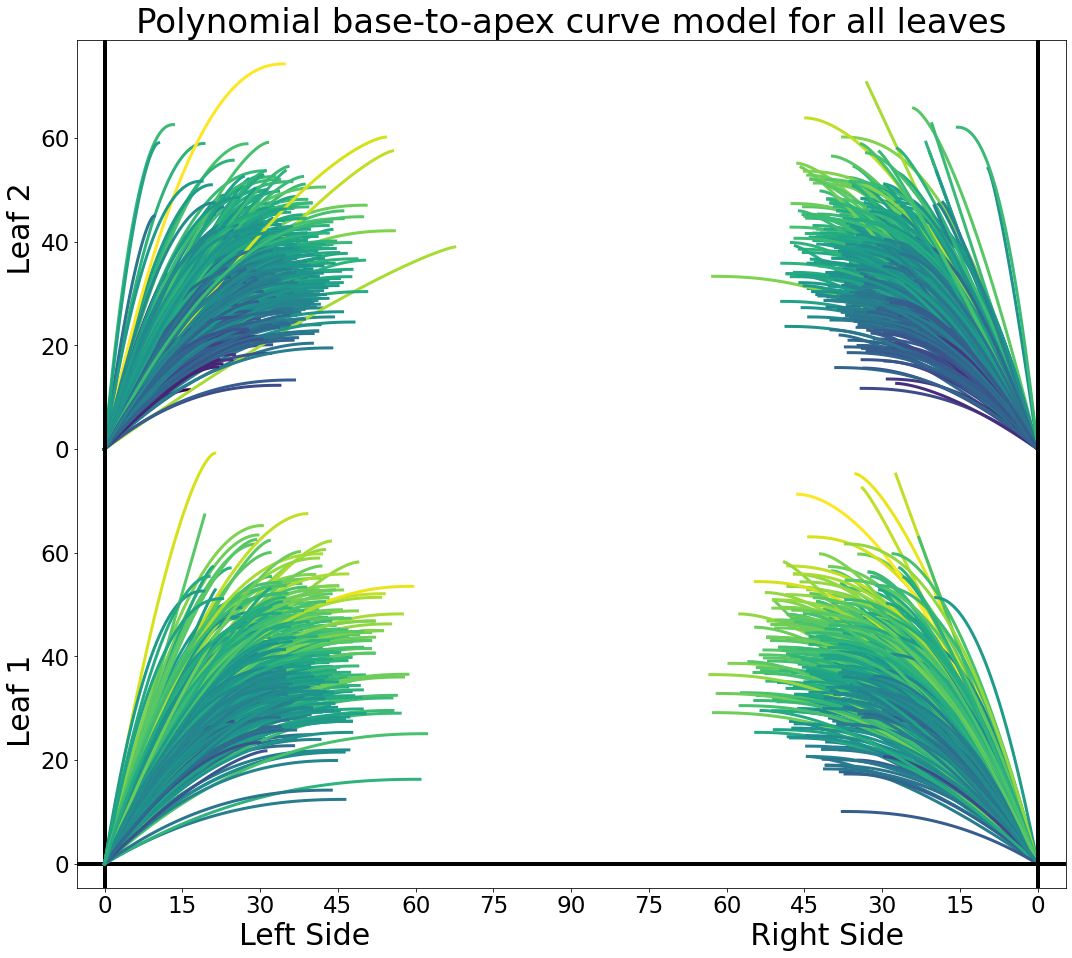

In [313]:
foo = [np.nonzero(1 - data[i]['curled'].values)[0] for i in range(len(data))]

bar = [(data[i].iloc[:,22]).values for i in range(len(data))]
mbar = np.min(np.hstack(bar))
Mbar = np.max(np.hstack(bar) - mbar)

color_vals = [(bar[i] - mbar)/Mbar for i in range(len(data))]

fs = 30
viridis = cm.get_cmap('viridis', 64)

xsep = 90; ysep = 80
fig, ax = plt.subplots(1,1, figsize=(15,15), sharex=True, sharey=True)
#ax = np.atleast_1d(ax).ravel()
#porder = [(1,0), (0,0), (1,1), (0,1)]
#psign = [1,1,-1,-1]
viridis = cm.get_cmap('viridis', 32)

i = 0
for j in range(len(data[i])):
    ax.plot(UPxrange[i][j], UPblade[i][j], lw=3, c=viridis(color_vals[i][j]), zorder=4)
    
i = 1
for j in range(len(data[i])):
    ax.plot(UPxrange[i][j], ysep+UPblade[i][j], lw=3, c=viridis(color_vals[i][j]))
    
i = 2
for j in range(len(data[i])):
    ax.plot(2*xsep - UPxrange[i][j], UPblade[i][j], lw=3, c=viridis(color_vals[i][j]))
    
i = 3
for j in range(len(data[i])):
    ax.plot(2*xsep - UPxrange[i][j], ysep+UPblade[i][j], lw=3, c=viridis(color_vals[i][j]))

ax.axvline(x=0, c='k', lw=4)
ax.axhline(y=0, c='k', lw=4)
ax.axvline(x=xsep*2, c='k', lw=4)
xticks = np.linspace(0,2*xsep,2*(xsep//15)+1)
xticklabels = np.hstack([xticks.astype(int)[:len(xticks)//2],
                         xticks.astype(int)[len(xticks)//2],
                         xticks.astype(int)[:len(xticks)//2][::-1]])
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.set_xlabel('Left Side' +40*' ' + 'Right Side', fontsize=fs)

yticks = np.linspace(0,2*ysep,2*(ysep//20)+1)
yticklabels = np.hstack([yticks.astype(int)[:len(yticks)//2],
                         yticks.astype(int)[0],
                         yticks.astype(int)[1:len(yticks)//2]])
ax.set_yticks(yticks[:-1])
ax.set_yticklabels(yticklabels)
ax.set_ylabel('Leaf 1' +40*' ' + 'Leaf 2', fontsize=fs)

ax.tick_params(labelsize=fs-7)
ax.set_aspect('equal')
ax.margins(0.03)

ax.set_title('Polynomial base-to-apex curve model for all leaves', fontsize=fs+4)

fig.tight_layout()

filename = dst + 'poly_model_all_upblades.png'
print(filename)
plt.savefig(filename, dpi=150, format='png', bbox_inches='tight', facecolor='white', transparent=False)

../model/poly_model_all_dwblades.png


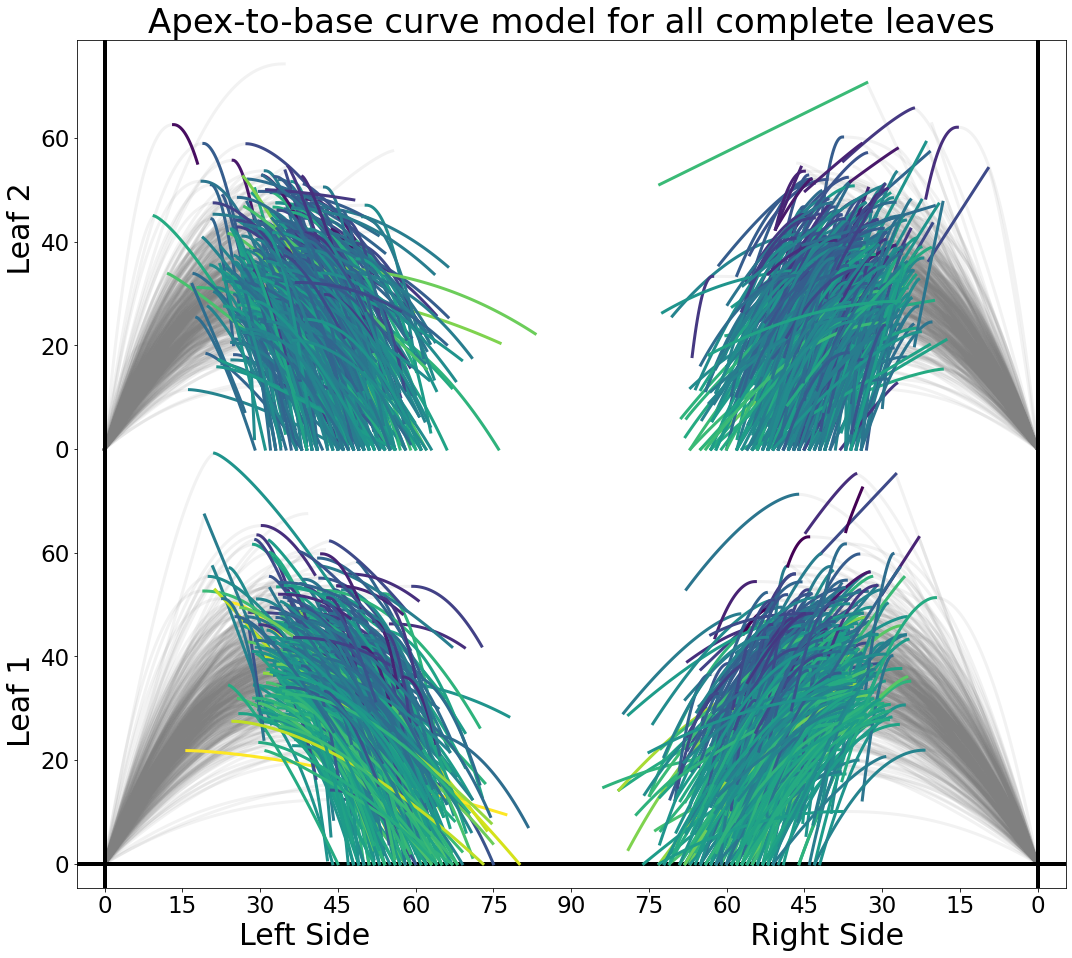

In [314]:
foo = [np.nonzero(1 - data[i]['curled'].values)[0] for i in range(len(data))]

bar = [(data[i].iloc[foo[i],23]).values for i in range(len(data))]
mbar = np.min(np.hstack(bar))
Mbar = np.max(np.hstack(bar) - mbar)

color_vals = [(bar[i] - mbar)/Mbar for i in range(len(data))]

fs = 30
viridis = cm.get_cmap('viridis', 64)

xsep = 90; ysep = 80
fig, ax = plt.subplots(1,1, figsize=(15,15), sharex=True, sharey=True)
#ax = np.atleast_1d(ax).ravel()
#porder = [(1,0), (0,0), (1,1), (0,1)]
#psign = [1,1,-1,-1]
viridis = cm.get_cmap('viridis', 32)

i = 0
for j in range(len(foo[i])):
    ax.plot(UPxrange[i][foo[i][j]], UPblade[i][foo[i][j]], lw=3, c='gray', alpha=.1, zorder=1)
    ax.plot(DWxrange[i][foo[i][j]], DWblade[i][foo[i][j]], lw=3, c=viridis(color_vals[i][j]), zorder=4)
for j in range(len(antifoo[i][:10])):
    ax.plot(XRange[i][antifoo[i][j]], BLade[i][antifoo[i][j]], lw=3, c='gray', alpha=0.1, zorder=1)
    
i = 1
for j in range(len(foo[i])):
    ax.plot(UPxrange[i][foo[i][j]], ysep+UPblade[i][foo[i][j]], lw=3, c='gray', alpha=.1, zorder=1)
    ax.plot(DWxrange[i][foo[i][j]], ysep+DWblade[i][foo[i][j]], lw=3, c=viridis(color_vals[i][j]), zorder=4)
for j in range(len(antifoo[i][:10])):
    ax.plot(XRange[i][antifoo[i][j]], ysep + BLade[i][antifoo[i][j]], lw=3, c='gray', alpha=0.1, zorder=1)
    
i = 2
for j in range(len(foo[i])):
    ax.plot(2*xsep-UPxrange[i][foo[i][j]], UPblade[i][foo[i][j]], lw=3, c='gray', alpha=.1, zorder=1)
    ax.plot(2*xsep-DWxrange[i][foo[i][j]], DWblade[i][foo[i][j]], lw=3, c=viridis(color_vals[i][j]), zorder=4)
for j in range(len(antifoo[i][:10])):
    ax.plot(2*xsep - XRange[i][antifoo[i][j]], BLade[i][antifoo[i][j]], lw=3, c='gray', alpha=0.1, zorder=1)
    
i = 3
for j in range(len(foo[i])):
    ax.plot(2*xsep-UPxrange[i][foo[i][j]], ysep+UPblade[i][foo[i][j]], lw=3, c='gray', alpha=.1, zorder=1)
    ax.plot(2*xsep-DWxrange[i][foo[i][j]], ysep+DWblade[i][foo[i][j]], lw=3, c=viridis(color_vals[i][j]), zorder=4)
for j in range(len(antifoo[i][:10])):
    ax.plot(2*xsep - XRange[i][antifoo[i][j]], ysep+BLade[i][antifoo[i][j]], lw=3, c='gray', alpha=0.1, zorder=1)
    
ax.axvline(x=0, c='k', lw=4)
ax.axhline(y=0, c='k', lw=4)
ax.axvline(x=xsep*2, c='k', lw=4)
xticks = np.linspace(0,2*xsep,2*(xsep//15)+1)
xticklabels = np.hstack([xticks.astype(int)[:len(xticks)//2],
                         xticks.astype(int)[len(xticks)//2],
                         xticks.astype(int)[:len(xticks)//2][::-1]])
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.set_xlabel('Left Side' +40*' ' + 'Right Side', fontsize=fs)

yticks = np.linspace(0,2*ysep,2*(ysep//20)+1)
yticklabels = np.hstack([yticks.astype(int)[:len(yticks)//2],
                         yticks.astype(int)[0],
                         yticks.astype(int)[1:len(yticks)//2]])
ax.set_yticks(yticks[:-1])
ax.set_yticklabels(yticklabels)
ax.set_ylabel('Leaf 1' +40*' ' + 'Leaf 2', fontsize=fs)

ax.tick_params(labelsize=fs-7)
ax.set_aspect('equal')
ax.margins(0.03)

ax.set_title('Apex-to-base curve model for all complete leaves', fontsize=fs+4)

fig.tight_layout()

filename = dst + 'poly_model_all_dwblades.png'
print(filename)
plt.savefig(filename, dpi=150, format='png', bbox_inches='tight', facecolor='white', transparent=False)

../model/poly_model_all_upblades_alternate.png


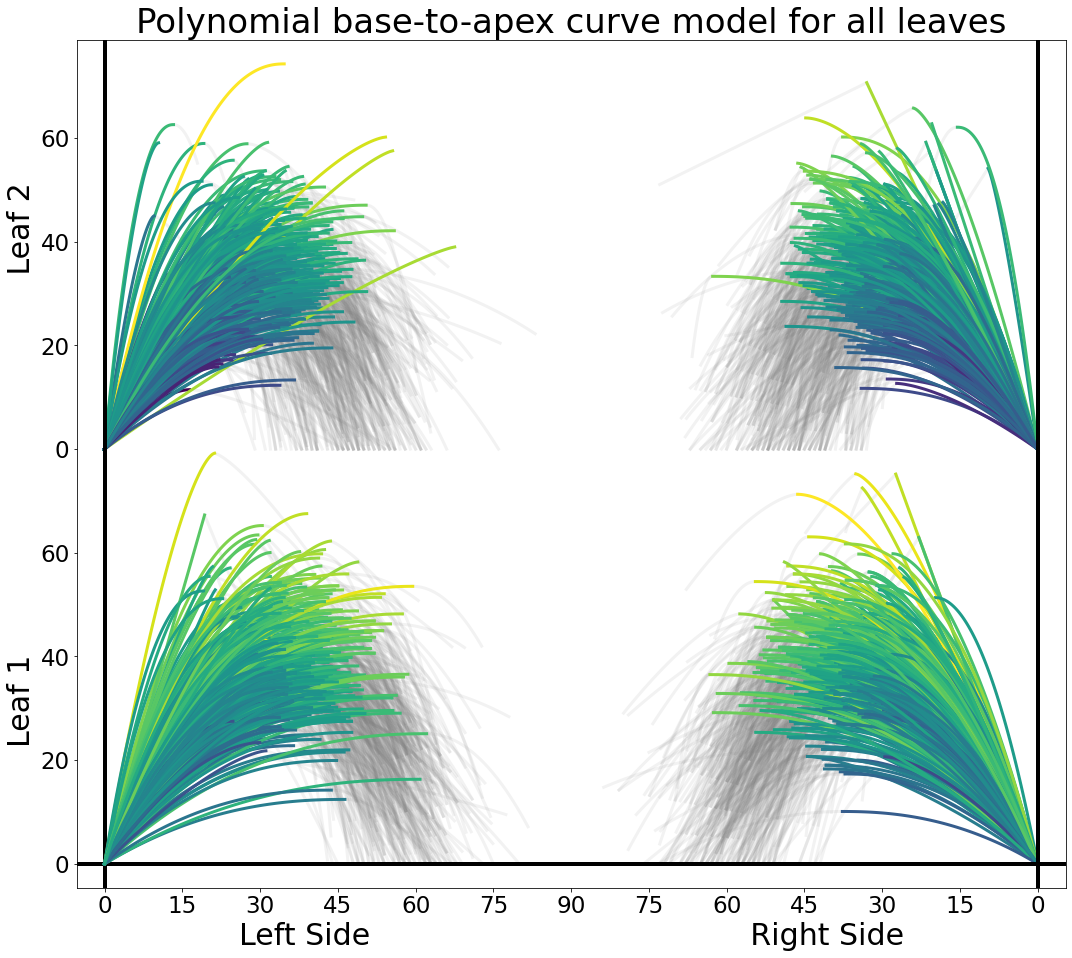

In [316]:
foo = [np.nonzero(1 - data[i]['curled'].values)[0] for i in range(len(data))]

bar = [(data[i].iloc[:,22]).values for i in range(len(data))]
mbar = np.min(np.hstack(bar))
Mbar = np.max(np.hstack(bar) - mbar)

color_vals = [(bar[i] - mbar)/Mbar for i in range(len(data))]

fs = 30
viridis = cm.get_cmap('viridis', 64)

xsep = 90; ysep = 80
fig, ax = plt.subplots(1,1, figsize=(15,15), sharex=True, sharey=True)
#ax = np.atleast_1d(ax).ravel()
#porder = [(1,0), (0,0), (1,1), (0,1)]
#psign = [1,1,-1,-1]
viridis = cm.get_cmap('viridis', 32)

i = 0
for j in range(len(data[i])):
    ax.plot(UPxrange[i][j], UPblade[i][j], lw=3, c=viridis(color_vals[i][j]), zorder=4)
    ax.plot(DWxrange[i][j], DWblade[i][j], lw=3, c='gray', alpha=0.1, zorder=1)
    
i = 1
for j in range(len(data[i])):
    ax.plot(UPxrange[i][j], ysep+UPblade[i][j], lw=3, c=viridis(color_vals[i][j]))
    ax.plot(DWxrange[i][j], ysep+DWblade[i][j], lw=3, c='gray', alpha=0.1, zorder=1)
    
i = 2
for j in range(len(data[i])):
    ax.plot(2*xsep - UPxrange[i][j], UPblade[i][j], lw=3, c=viridis(color_vals[i][j]))
    ax.plot(2*xsep - DWxrange[i][j], DWblade[i][j], lw=3, c='gray', alpha=0.1, zorder=1)
    
i = 3
for j in range(len(data[i])):
    ax.plot(2*xsep - UPxrange[i][j], ysep+UPblade[i][j], lw=3, c=viridis(color_vals[i][j]))
    ax.plot(2*xsep - DWxrange[i][j], ysep+DWblade[i][j], lw=3, c='gray', alpha=0.1, zorder=1)

ax.axvline(x=0, c='k', lw=4)
ax.axhline(y=0, c='k', lw=4)
ax.axvline(x=xsep*2, c='k', lw=4)
xticks = np.linspace(0,2*xsep,2*(xsep//15)+1)
xticklabels = np.hstack([xticks.astype(int)[:len(xticks)//2],
                         xticks.astype(int)[len(xticks)//2],
                         xticks.astype(int)[:len(xticks)//2][::-1]])
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.set_xlabel('Left Side' +40*' ' + 'Right Side', fontsize=fs)

yticks = np.linspace(0,2*ysep,2*(ysep//20)+1)
yticklabels = np.hstack([yticks.astype(int)[:len(yticks)//2],
                         yticks.astype(int)[0],
                         yticks.astype(int)[1:len(yticks)//2]])
ax.set_yticks(yticks[:-1])
ax.set_yticklabels(yticklabels)
ax.set_ylabel('Leaf 1' +40*' ' + 'Leaf 2', fontsize=fs)

ax.tick_params(labelsize=fs-7)
ax.set_aspect('equal')
ax.margins(0.03)

ax.set_title('Polynomial base-to-apex curve model for all leaves', fontsize=fs+4)

fig.tight_layout()

filename = dst + 'poly_model_all_upblades_alternate.png'
print(filename)
plt.savefig(filename, dpi=150, format='png', bbox_inches='tight', facecolor='white', transparent=False)

## Make individual blade model plots

In [ ]:
dst = '../model/rpl1/'

importlib.reload(maize)
for idx in range(len(degs)):
    title = '.'.join(numbers.columns[0].split('.')[:2]) + ' ' + PlotData.iloc[idx,0]
    deg = np.sort(degs[idx])
    deg = 90 - deg
    if deg[0] > 89:
        deg[0] = 89
    
    maize.plot_poly_blade([Blade[idx]], deg, [Params[idx]], 
                          title=title, labels=['Polymodel'], dpi=40, dst=dst,
                         writefig=True)